# The Non Random Two Liquids (NRTL) model for *excess Gibbs energy* ($g^E$) and a case study of the Liquid-Liquid equilibria of water+acetone.

## Fitted parameters
from Understanding Distillation Using Column Profile Maps, Author(s): Daniel Beneke, Mark Peters, David Glasser, Diane Hildebrandt

http://onlinelibrary.wiley.com/doi/10.1002/9781118477304.app2/pdf

ran at 293.15K

In [14]:
# Acetone (1) + water (2)


alpha12 = 0.3

Dg12 = 3623.69184608 #J/mol
Dg21 = 553.52435239 #J/mol

#alpha = 0.4

# 6 binary Aij parameters
#Dg12 = 12.2e3 #J/mol
#Dg21 = 3e3 #J/mol

## Feeding the fitted parameters to the model in matrix structure:
we will assemble the parameters in a matrix structure so that we can access each parameter by its index, as in
`A[0,0]` and `A[0,1]`rather than as `A11` and `A12`, so we can loop trough all of them using an iterator, see below:

In [15]:
import numpy as np
from scipy.constants import R

In [16]:
#assemble matrix with regressed parameters Dg_i,j, according to the model all diagonal terms are zero
Dg = np.array([[0, Dg12],
             [Dg21, 0]])

A = Dg/R

#assemble symmetric matrix alpha
alpha = np.array([[0, alpha12],
                [alpha12, 0]])

In [17]:
from numba import jit
@jit
def Gamma(T,c_x,q_alpha, q_A):
    #note that we used many lines for didatics
    #we can do it in few lines:
    #note that some expression occur more than once below
    #so it may be useful define it as a intermediary recurrent term here
    #and calculate it once to use it then several times
    q_tau     = q_A/T
    q_G       = np.exp(-(q_alpha*q_tau))
    l_D       = ((1/((q_G.T) @ c_x)).T)
    q_E       = (q_tau*q_G) * l_D 
    gamma     = np.exp(((q_E+(q_E.T))-(((q_G * l_D) * (c_x.T)) @ (q_E.T))) @ c_x)
    return gamma

In [18]:
#test it to see that the results are the same
T=293.15
x=np.array([.4,.6]) #normalized
x_as_column = np.array([x]).T
print(Gamma(T,x_as_column,alpha,A)) #test using those trial input

[[ 1.72437107]
 [ 1.18508641]]


In [19]:
#Calculo de Psat com a Equação de Antoine
#Pressões de saturação para entrar em yi.Pbol = xi*Gammai*P_sati
#T = 373

def PantoineW(T):
    Aw = 16.3872
    Bw = 3885.70
    Cw = 230.170
    return (np.exp(Aw - Bw/(T-273 + Cw)))*1000
PsatAw = PantoineW(T)
print (PsatAw)

def PantoineA(T):
    Aa = 14.3145
    Ba = 2756.22
    Ca = 228.06
    return (np.exp(Aa - Ba/(T-273 + Ca)))*1000
PsatAa = PantoineA(T)
print (PsatAa)

PsatAw = PantoineW(373)
print (PsatAw)

2373.27142449
24781.8761627
101333.212771


In [20]:
import matplotlib.pyplot as plt
def Pbol(x,T):
    y_out = np.zeros(2)
    gammas = Gamma(T,x,alpha,A)
    Psati = ([PsatAw,PsatAa])
    Pbol_=0
    for i in range(0,2):
#        print(i,Pbol_)
        Pbol_ += x[i]*gammas[i]*Psati[i]
    
    #calculo das composicoes do vapor
    for i in range(0,2):
        y_out[i] = x[i]*gammas[i]*Psati[i]/Pbol_
        
        
#    print(y_out, Gamma, x, Psati, Pbol_)
    return [y_out, Pbol_]

def Pbol_MisturaIDEAL(x,T):
    y_out = np.zeros(2)
    gammas = [1,1]
    Psati = ([PsatAw,PsatAa])
    Pbol_=0
    for i in range(0,2):
#        print(i,Pbol_)
        Pbol_ += x[i]*gammas[i]*Psati[i]
    
    #calculo das composicoes do vapor
    for i in range(0,2):
        y_out[i] = x[i]*gammas[i]*Psati[i]/Pbol_
        
        
#    print(y_out, Gamma, x, Psati, Pbol_)
    return [y_out, Pbol_]



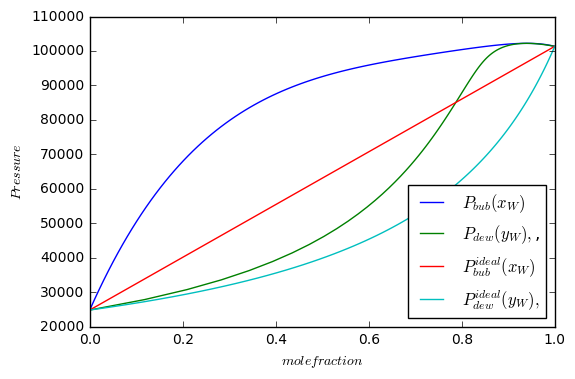

comportamento tipo azeotropia de máximo em P indica tipo azeotropia de mńimo em T


In [21]:
xwaxis = np.linspace (0,1,100)
P_axis = np.zeros(100)
ywaxis = np.zeros(100)
for i in range (0,100):
    xa = 1-xwaxis[i]
    x_ = np.array([[xwaxis[i],xa]]).T
    y_, P_axis[i] = Pbol(x_,T)
    ywaxis[i] = y_[0]

plt.figure(1)
plt.plot(xwaxis,P_axis)
plt.plot(ywaxis,P_axis)

xwaxis = np.linspace (0,1,100)
P_axis = np.zeros(100)
ywaxis = np.zeros(100)
for i in range (0,100):
    xa = 1-xwaxis[i]
    x_ = [xwaxis[i],xa]
    y_, P_axis[i] = Pbol_MisturaIDEAL(x_,T)
    ywaxis[i] = y_[0]

plt.plot(xwaxis,P_axis)
plt.plot(ywaxis,P_axis)

labels = [r'$P_{bub}(x_W)$', r'$P_{dew}(y_W),$,',r'$P^{ideal}_{bub}(x_W)$', r'$P^{ideal}_{dew}(y_W),$']
plt.legend(labels, loc=4)

plt.ylabel(r'$Pressure$')
plt.xlabel(r'$mole fraction$')

plt.show()

print("comportamento tipo azeotropia de máximo em P indica tipo azeotropia de mńimo em T")

#min em T aqui: http://www.ddbst.com/en/EED/VLE/VLE%20Acetone%3BWater.php



In [22]:
# exp data rip of http://www.ddbst.com/en/EED/VLE/VLE%20Acetone%3BWater.php

In [23]:
table101=np.loadtxt('dados101.txt', skiprows=1)
table344=np.loadtxt('dados344.txt', skiprows=1)
table689=np.loadtxt('dados689.txt', skiprows=1)
iA=1
iW=2

In [24]:
print("T,xA,yA")
print(table101)
print(table344)
print(table689)

T,xA,yA
[[  3.68250000e+02   8.00000000e-03   1.38000000e-01]
 [  3.63250000e+02   1.60000000e-02   2.77000000e-01]
 [  3.55250000e+02   3.30000000e-02   4.79000000e-01]
 [  3.49350000e+02   5.20000000e-02   6.04000000e-01]
 [  3.45350000e+02   7.20000000e-02   6.75000000e-01]
 [  3.42650000e+02   9.40000000e-02   7.19000000e-01]
 [  3.40750000e+02   1.17000000e-01   7.38000000e-01]
 [  3.38150000e+02   1.71000000e-01   7.76000000e-01]
 [  3.36450000e+02   2.37000000e-01   8.00000000e-01]
 [  3.35150000e+02   3.18000000e-01   8.22000000e-01]
 [  3.34150000e+02   4.20000000e-01   8.39000000e-01]
 [  3.33050000e+02   5.54000000e-01   8.63000000e-01]
 [  3.31350000e+02   7.36000000e-01   9.09000000e-01]]
[[  3.95650000e+02   1.70000000e-02   3.49000000e-01]
 [  3.93150000e+02   2.40000000e-02   3.98000000e-01]
 [  3.85150000e+02   5.50000000e-02   5.18000000e-01]
 [  3.79150000e+02   1.07000000e-01   6.08000000e-01]
 [  3.75950000e+02   1.94000000e-01   6.70000000e-01]
 [  3.74450000e+02 

In [25]:
nlines=0
nP=0
tables=[table101,table344,table689]

for i in range(3):
    nlines = tables[i].shape[0]
    print(nlines)
    nP += nlines

Pcalc=np.zeros(nP)
ycalc=np.zeros(nP)

Pcalc_ideal=np.zeros(nP)
ycalc_ideal=np.zeros(nP)

Pexp_levels=[101,344,689]
Pexp=np.zeros(nP)
yexp=np.zeros(nP)
Texp=np.zeros(nP)
xexp=np.zeros([nP,2])
metrics=np.zeros(nP)
residuolog=np.zeros(nP)
P_calc_ideal=np.zeros(nP)
k=0
summres=0
for i in range(3):
    nlines = tables[i].shape[0]
    for j in range(nlines):
        Pexp[k]=Pexp_levels[i]*1000
        yexp[k]=tables[i][j][2]
        xA = tables[i][j][1]
        xexp[k,:] = [xA,1-xA]
        Texp[k] = tables[i][j][0]
        ans=Pbol(xexp[k,:],Texp[k])
        ycalc[k]=ans[0][0]
        Pcalc[k]=ans[1]
        
        ans=Pbol_MisturaIDEAL(xexp[k,:],Texp[k])
        ycalc_ideal[k]=ans[0][0]
        Pcalc_ideal[k]=ans[1]
        
        dpnrtl= Pcalc[k]-Pexp[k] # close to zero
        dpideal = Pcalc_ideal[k]-Pexp[k] # propagation of non ideality of liquid phase interactions into equilibrium pressure of the system
        
        # metrics we want 

        # some res which is zero for total fit
        # is 0-1 for better than IG
        # is more than 1 for worse then IG
        
        metrics[k] = np.abs(dpnrtl/dpideal)
        
        #residuolog[k] = (np.log(Pexp[k])-np.log(Pcalc[k]))*100/np.log((Pexp[k]))
        
        #summres += np.abs(residuolog[k])
        
        summres += np.abs(metrics[k])
        
        print(Pexp[k],Pcalc[k],metrics[k],"% na escala log")
        k+=1

#all metrics bigger than 1 when signla reversed in NRTL model
# average metrics of 0.7 with correct implementation
        
print(summres/nP)
plt.show()

13
12
11
101000.0 26784.5936256 0.981611088473 % na escala log
101000.0 28778.0703096 0.963045063085 % na escala log
101000.0 32938.6384982 0.923593149913 % na escala log
101000.0 37403.5582566 0.880380438791 % na escala log
101000.0 41845.1300941 0.836626483794 % na escala log
101000.0 46402.1248627 0.791017925572 % na escala log
101000.0 50815.1107131 0.74611481535 % na escala log
101000.0 59873.542994 0.651478865236 % na escala log
101000.0 68798.0910119 0.554483952733 % na escala log
101000.0 77160.1489478 0.459565176263 % na escala log
101000.0 84639.900205 0.371258815778 % na escala log
101000.0 91090.9206656 0.293092730939 % na escala log
101000.0 96803.9897739 0.211105777337 % na escala log
344000.0 28751.9237983 0.991605743001 % na escala log
344000.0 30352.4246428 0.988237110367 % na escala log
344000.0 37133.2718826 0.974155966303 % na escala log
344000.0 47204.298124 0.954243769967 % na escala log
344000.0 60625.9771533 0.931026917044 % na escala log
344000.0 69844.1348162 